# DATA PREPARATION

### 1. Importação de Bibliotecas

In [103]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import joblib
import os
import seaborn as sns
from src.data.process_data import  handle_duplicates
from src.visualizations.plot_results import plot_box_and_bar_spark, plot_rfm_relationships, plot_qq_pyspark, plot_histograms, plot_pca_loadings,plot_distribution_hist
from pyspark.sql.functions import col, sum, to_date, round, pandas_udf, PandasUDFType,concat_ws
from pyspark.sql import functions as F
from sklearn.preprocessing import PowerTransformer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.feature import MaxAbsScaler, VectorAssembler
from builtins import sum
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from factor_analyzer import FactorAnalyzer


### 2. Inicialização da SparkSession e Carregamento dos Dados

In [104]:
# Importando a biblioteca correta
from pyspark.sql import SparkSession

# Inicializar uma nova sessão Spark
spark = SparkSession.builder \
    .appName("Feature Engineering") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrationRequired", "false") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

# Configurar o parser de datas
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Verificar se SparkSession foi inicializada corretamente
print(spark)

In [105]:

# Obter o caminho absoluto do projeto e diretório interim
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))
src_path = os.path.join(project_path, 'RID184082_Desafio07/project/src/data/interim')

# Carregar os limites previamente salvos
lower_Quantity_bound = joblib.load(os.path.join(src_path, 'lower_Quantity_bound.pkl'))
upper_Quantity_bound = joblib.load(os.path.join(src_path, 'upper_Quantity_bound.pkl'))
lower_UnitPrice_bound = joblib.load(os.path.join(src_path, 'lower_UnitPrice_bound.pkl'))
upper_UnitPrice_bound = joblib.load(os.path.join(src_path, 'upper_UnitPrice_bound.pkl'))

print("Limites carregados com sucesso!")
print(f"Lower Quantity Bound: {lower_Quantity_bound}")
print(f"Upper Quantity Bound: {upper_Quantity_bound}")
print(f"Lower UnitPrice Bound: {lower_UnitPrice_bound}")
print(f"Upper UnitPrice Bound: {upper_UnitPrice_bound}")



Limites carregados com sucesso!
Lower Quantity Bound: 0.0
Upper Quantity Bound: 23.5
Lower UnitPrice Bound: 0.0
Upper UnitPrice Bound: 8.45


In [106]:
print(f"Caminho completo gerado: {src_path}")

Caminho completo gerado: /Users/rodrigocampos/Documents/RID184082_Desafio07/project/src/data/interim


#### Carregando base de dados

In [107]:
# Caminho do arquivo Parquet
input_path = "project/src/data/raw/data.parquet"

# Carregar o DataFrame
df = spark.read.parquet(input_path)

# Mostrar as primeiras linhas
df.show(5, truncate=False)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|549251   |84596F   |SMALL MARSHMALLOWS PINK BOWL       |2       |4/7/2011 12:16|0.42     |14449     |United Kingdom|
|549251   |21975    |PACK OF 60 DINOSAUR CAKE CASES     |1       |4/7/2011 12:16|0.55     |14449     |United Kingdom|
|549251   |22417    |PACK OF 60 SPACEBOY CAKE CASES     |1       |4/7/2011 12:16|0.55     |14449     |United Kingdom|
|549251   |22326    |ROUND SNACK BOXES SET OF4 WOODLAND |1       |4/7/2011 12:16|2.95     |14449     |United Kingdom|
|549251   |22327    |ROUND SNACK BOXES SET OF 4 SKULLS  |1       |4/7/2011 12:16|2.95     |14449     |United Kingdom|
+---------+---------+-----------------------------------

#### 3. Remoção de Outliers usando IQR

In [108]:
# Mostrar o número de linhas antes do filtro
linhas_antes = df.count()
print(f"Número de linhas antes da remoção de outliers: {linhas_antes}")

# Filtrar valores de Quantity e UnitPrice dentro dos limites
df_filtrado = df.filter(
    (col("Quantity") >= lower_Quantity_bound) & (col("Quantity") <= upper_Quantity_bound) &
    (col("UnitPrice") >= lower_UnitPrice_bound) & (col("UnitPrice") <= upper_UnitPrice_bound)
)

# Mostrar o número de linhas após o filtro
linhas_depois = df_filtrado.count()
print(f"Número de linhas após a remoção de outliers: {linhas_depois}")

# Exibir a quantidade de outliers removidos
outliers_removidos = linhas_antes - linhas_depois
print(f"Número de outliers removidos: {outliers_removidos}")

# Verificar os dados filtrados
# df_filtrado.show(5)

Número de linhas antes da remoção de outliers: 541909
Número de linhas após a remoção de outliers: 437073
Número de outliers removidos: 104836


### 4. Tratamento  dos Dados

#### Tratando Valores Nulos

In [109]:
from pyspark.sql.functions import col, sum
# Contar valores nulos por coluna corretamente
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [110]:
print(f" Valores nulos no dataframe após o Dropna: ")
# Excluir linhas com nulos, se necessário
df = df.dropna()
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

 Valores nulos no dataframe após o Dropna: 
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|          0|       0|          0|        0|         0|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



#### Tratando Linhas Duplicadas

In [111]:
handle_duplicates(df)

Número de linhas duplicadas encontradas: 5225


Número de linhas duplicadas após remoção: 0


In [112]:
df = df.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))

### 5. Conversões e Extrações Úteis

#### Conversão de Tipos

In [113]:
# Converter InvoiceNo para inteiro
df = df.withColumn("InvoiceNo", col("InvoiceNo").cast("int"))

# Converter 'InvoiceDate' para o tipo datetime (no PySpark)
df = df.withColumn("InvoiceDate", to_date(col("InvoiceDate"), "MM/dd/yyyy HH:mm"))

# Arredondar UnitPrice para 2 casas decimais
df = df.withColumn("UnitPrice", round(col("UnitPrice"), 2))

In [114]:
df.printSchema()

root
 |-- InvoiceNo: integer (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



### 6. Cálculo das Métricas RFM (Recency, Frequency, Monetary)

In [115]:
# Determinar dinamicamente a data de referência
max_date = df.select(F.max("InvoiceDate")).collect()[0][0]

# Reparticionar os dados para melhorar o desempenho (opcional)
df = df.repartition(100, "CustomerID")  # Ajuste o número de partições conforme necessário

# Calcular as métricas de RFM
df_rfm = df.groupBy("CustomerID").agg(
    F.datediff(F.lit(max_date), F.max("InvoiceDate")).alias("Recency"),
    F.count("InvoiceNo").alias("Frequency"),
    F.sum(F.col("Quantity") * F.col("UnitPrice")).alias("Monetary")
).cache()  # Cache para reutilizar os resultados de RFM

# Calcular os Scores de RFM usando percentis
# Percentis manuais para garantir o mínimo número de nós
recency_percentiles = df_rfm.approxQuantile("Recency", [0.2, 0.4, 0.6, 0.8], 0)
frequency_percentiles = df_rfm.approxQuantile("Frequency", [0.2, 0.4, 0.6, 0.8], 0)
monetary_percentiles = df_rfm.approxQuantile("Monetary", [0.2, 0.4, 0.6, 0.8], 0)

# Funções UDF para mapear os Scores de RFM
def assign_recency_score(recency):
    if recency <= recency_percentiles[0]:
        return 5
    elif recency <= recency_percentiles[1]:
        return 4
    elif recency <= recency_percentiles[2]:
        return 3
    elif recency <= recency_percentiles[3]:
        return 2
    else:
        return 1

def assign_other_scores(value, percentiles):
    if value <= percentiles[0]:
        return 1
    elif value <= percentiles[1]:
        return 2
    elif value <= percentiles[2]:
        return 3
    elif value <= percentiles[3]:
        return 4
    else:
        return 5

# Registrar UDFs
assign_recency_udf = F.udf(assign_recency_score, "int")
assign_other_udf = F.udf(lambda x: assign_other_scores(x, frequency_percentiles), "int")
assign_monetary_udf = F.udf(lambda x: assign_other_scores(x, monetary_percentiles), "int")

# Adicionar Scores de RFM ao DataFrame
df_rfm = df_rfm.withColumn("Recency_score", assign_recency_udf(F.col("Recency")))
df_rfm = df_rfm.withColumn("Frequency_score", assign_other_udf(F.col("Frequency")))
df_rfm = df_rfm.withColumn("Monetary_score", assign_monetary_udf(F.col("Monetary")))

# Calcular o RFM final concatenando os scores
df_rfm = df_rfm.withColumn("RFM",concat_ws("", col("Recency_score").cast("string"),
                                               col("Frequency_score").cast("string"),
                                               col("Monetary_score").cast("string")).cast("int") )

# Exibir o resultado final
df_rfm.show(truncate=False)

25/01/29 19:38:06 WARN CacheManager: Asked to cache already cached data.


+----------+-------+---------+------------------+-------------+---------------+--------------+---+
|CustomerID|Recency|Frequency|Monetary          |Recency_score|Frequency_score|Monetary_score|RFM|
+----------+-------+---------+------------------+-------------+---------------+--------------+---+
|14395     |2      |350      |3507.710000000001 |5            |5              |5             |555|
|17389     |0      |213      |31833.680000000015|5            |5              |5             |555|
|14450     |180    |40       |483.25            |1            |3              |2             |132|
|16735     |78     |125      |2300.5599999999977|2            |5              |5             |255|
|13285     |23     |187      |2709.1199999999994|4            |5              |5             |455|
|16990     |218    |1        |179.0             |1            |1              |1             |111|
|16503     |106    |84       |1431.9300000000007|2            |4              |4             |244|
|17764    

In [116]:
print(f"Total de linhas antes do agrupamento: {df.count()}")

unique_customers = df.select("CustomerID").distinct().count()
print(f"Total de clientes únicos: {unique_customers}")

Total de linhas antes do agrupamento: 397884
Total de clientes únicos: 4338


In [117]:
df_rfm.describe(["Recency", "Frequency", "Monetary"]).show()

+-------+------------------+------------------+-----------------+
|summary|           Recency|         Frequency|         Monetary|
+-------+------------------+------------------+-----------------+
|  count|              4338|              4338|             4338|
|   mean| 92.05947441217151| 91.72060857538035|2054.266459197787|
| stddev|100.01226424171826|228.78509387327043|8989.230441421172|
|    min|                 0|                 1|             3.75|
|    max|               373|              7847|        280206.02|
+-------+------------------+------------------+-----------------+



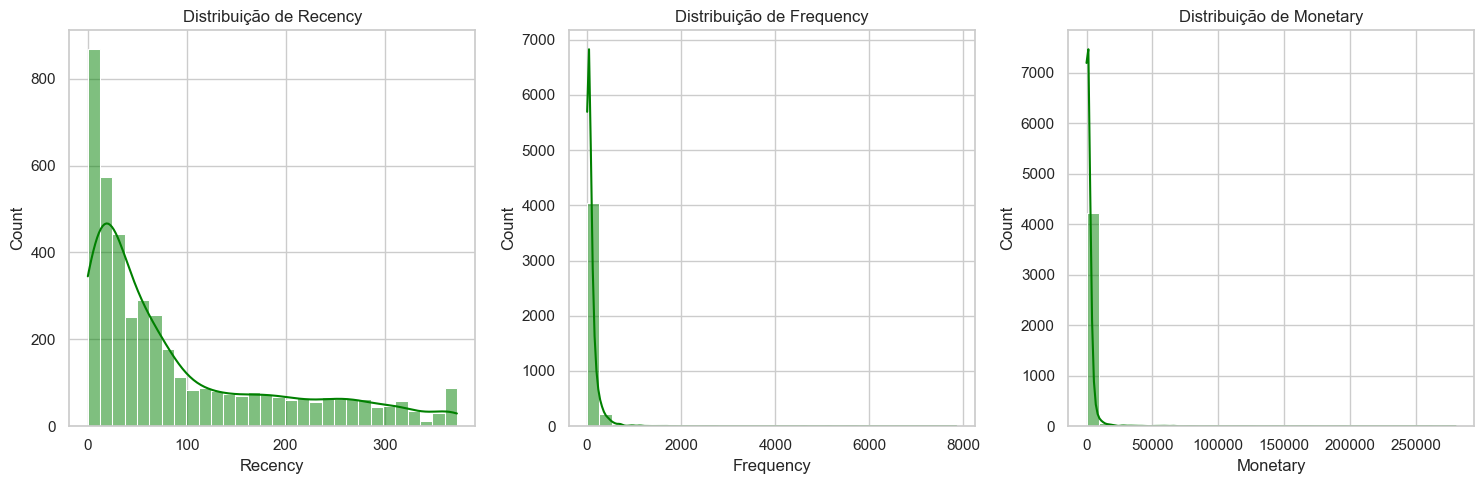

In [118]:
df_pandas_rfm = df_rfm.select("Recency", "Frequency", "Monetary").toPandas()
plot_distribution_hist(df_pandas_rfm, columns=["Recency", "Frequency", "Monetary"])

In [119]:
from pyspark.sql.functions import skewness, kurtosis

# Calcular assimetria e curtose para as colunas
columns = ["Recency", "Frequency", "Monetary"]

for col_name in columns:
    skewness_value = df_rfm.select(skewness(col_name)).first()[0]
    kurtosis_value = df_rfm.select(kurtosis(col_name)).first()[0]
    
    print(f"Coluna: {col_name}")
    print(f"  Assimetria (Skewness): {skewness_value:.4f}")
    print(f"  Curtose (Kurtosis): {kurtosis_value:.4f}")
    print()

Coluna: Recency
  Assimetria (Skewness): 1.2454
  Curtose (Kurtosis): 0.4286

Coluna: Frequency
  Assimetria (Skewness): 18.0999
  Curtose (Kurtosis): 482.8733

Coluna: Monetary
  Assimetria (Skewness): 19.3183
  Curtose (Kurtosis): 477.4959



### 7. Normalização de Dados

**A transformação dos dados utilizada foi Yeo-Johnson, que é definida como:**

$
\begin{aligned}
T_{\lambda}(x) =
\begin{cases}
\frac{(x+1)^{\lambda} - 1}{\lambda}, & \text{se } x \geq 0 \text{ e } \lambda \neq 0 \\
\ln(x + 1), & \text{se } x \geq 0 \text{ e } \lambda = 0 \\
-\frac{(-x+1)^{2 - \lambda} - 1}{2 - \lambda}, & \text{se } x < 0 \text{ e } \lambda \neq 2 \\
-\ln(-x + 1), & \text{se } x < 0 \text{ e } \lambda = 2
\end{cases}
\end{aligned}
$

**Onde:**
- $x$ é a variável original.
- $\lambda$ é o parâmetro de transformação ajustável para otimizar a normalidade dos dados.
- Se $\lambda = 0$, a transformação se reduz a um logaritmo para $x \geq 0$.
- Se $\lambda = 2$, a transformação usa um logaritmo para $x < 0$.  
  
**Observação:**  
Das transformações foi a que melhor reduziu a assimetria (skewness), tornando as distribuições das variáveis mais próximas da normalidade.




In [120]:
# Normalização dos dados
@pandas_udf(DoubleType())
def yeo_johnson_udf(series: pd.Series) -> pd.Series:
    pt = PowerTransformer(method="yeo-johnson")
    transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
    return pd.Series(transformed)

df_transformed = (df_rfm.withColumn("Recency_yeo", yeo_johnson_udf(col("Recency")))
                        .withColumn("Frequency_yeo", yeo_johnson_udf(col("Frequency")))
                        .withColumn("Monetary_yeo", yeo_johnson_udf(col("Monetary"))))

df_transformed.show(truncate=False)

+----------+-------+---------+------------------+-------------+---------------+--------------+---+--------------------+-------------------+--------------------+
|CustomerID|Recency|Frequency|Monetary          |Recency_score|Frequency_score|Monetary_score|RFM|Recency_yeo         |Frequency_yeo      |Monetary_yeo        |
+----------+-------+---------+------------------+-------------+---------------+--------------+---+--------------------+-------------------+--------------------+
|14395     |2      |350      |3507.710000000001 |5            |5              |5             |555|-1.6075178316514478 |1.7245595848729562 |1.1019063839766237  |
|17389     |0      |213      |31833.680000000015|5            |5              |5             |555|-1.868015058477526  |1.124232076331181  |2.070242225489797   |
|14450     |180    |40       |483.25            |1            |3              |2             |132|0.9033986973191453  |-0.393369897049488 |-0.2517726311793845 |
|16735     |78     |125      |2300

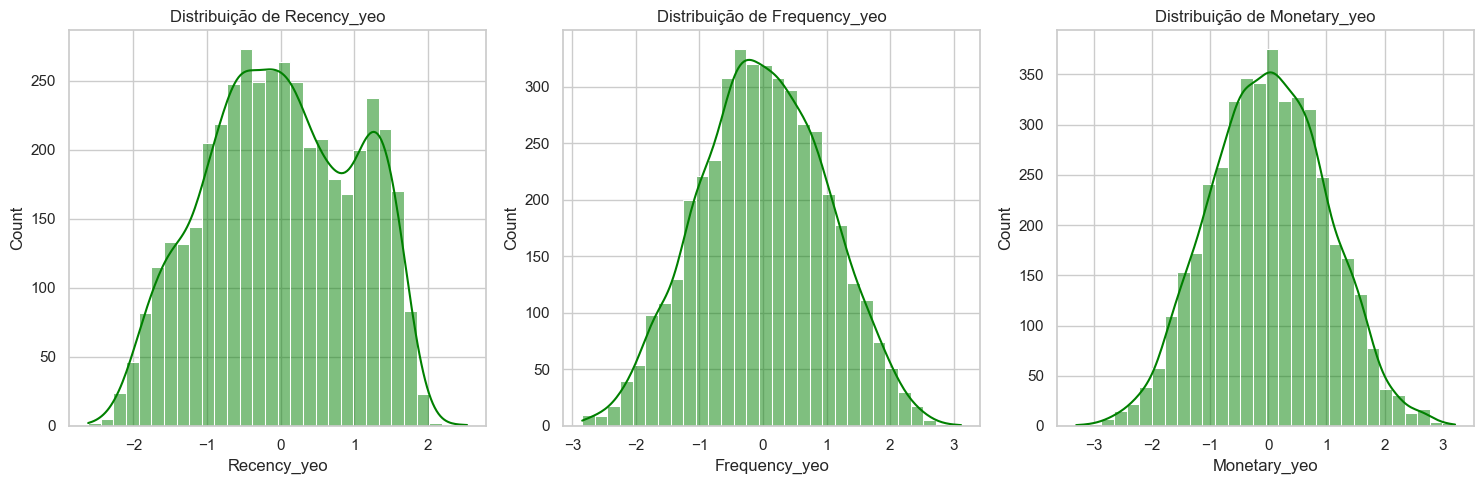

In [121]:
df_pandas_transformed = df_transformed.select("Recency_yeo", "Frequency_yeo", "Monetary_yeo").toPandas()
plot_distribution_hist(df_pandas_transformed, columns=["Recency_yeo", "Frequency_yeo", "Monetary_yeo"])

In [122]:
from pyspark.sql.functions import skewness, kurtosis

# Calcular assimetria e curtose para as colunas
columns = ["Recency_yeo", "Frequency_yeo", "Monetary_yeo"]

for col_name in columns:
    skewness_value = df_transformed.select(skewness(col_name)).first()[0]
    kurtosis_value = df_transformed.select(kurtosis(col_name)).first()[0]
    
    print(f"Coluna: {col_name}")
    print(f"  Assimetria (Skewness): {skewness_value:.4f}")
    print(f"  Curtose (Kurtosis): {kurtosis_value:.4f}")    

Coluna: Recency_yeo
  Assimetria (Skewness): -0.0641
  Curtose (Kurtosis): -0.8870


Coluna: Frequency_yeo
  Assimetria (Skewness): -0.0098
  Curtose (Kurtosis): -0.3834


Coluna: Monetary_yeo
  Assimetria (Skewness): 0.0131
  Curtose (Kurtosis): -0.2595


### 8. Escalonamento dos Dados

**A transformação dos dados utilizada foi MaxAbsScaler, que é definida como:**

$
X_{\text{scaled}} = \frac{X}{\max |X|}
$

**Onde:**
- $X$ é a variável original.
- $\max |X|$ é o maior valor absoluto da variável.
- A transformação resulta em valores no intervalo $[-1, 1]$.

**Observações:**  
1. Essa transformação foi utilizada pois mantém a normalização realizada anteriormente nos dados, garantindo que cada variável tenha um impacto proporcional e evitando distorções causadas por valores extremos.
2. Os modelos como o Fuzzy C-means e K-means se tornam mais eficiente quando os valores estão em torno de zero.

In [123]:
# Concatenação de colunas múltiplas em uma coluna tipo vetor
assembler = VectorAssembler(inputCols=["Recency_yeo", "Frequency_yeo", "Monetary_yeo"], outputCol="features_vector")
df_features = assembler.transform(df_transformed)

# Aplicando o escalonamento [-1, 1]
scaler = MaxAbsScaler(inputCol="features_vector", outputCol="maxAbsFeatures")
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

# Converter o vetor para um array para facilitar o acesso aos itens individualmente
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

df_scaled = df_scaled.withColumn("maxAbsArray", vector_to_array_udf(col("maxAbsFeatures")))

# Adicionar colunas normalizadas diretamente ao DataFrame original
df_scaled = (df_scaled.withColumn("Recency_scaled", col("maxAbsArray")[0])
                      .withColumn("Frequency_scaled", col("maxAbsArray")[1])
                      .withColumn("Monetary_scaled", col("maxAbsArray")[2]))

df_scaled = df_scaled.select("Recency", "Frequency", "Monetary",  "Recency_scaled", "Frequency_scaled", "Monetary_scaled","Recency_score", "Frequency_score", "Monetary_score", "CustomerID", "maxAbsFeatures", "features_vector","RFM")

df_scaled.show(truncate=False)
# df_scaled.cache()
df_scaled.unpersist()

+-------+---------+------------------+---------------------+---------------------+--------------------+-------------+---------------+--------------+----------+-----------------------------------------------------------------+---------------------------------------------------------------+---+
|Recency|Frequency|Monetary          |Recency_scaled       |Frequency_scaled     |Monetary_scaled     |Recency_score|Frequency_score|Monetary_score|CustomerID|maxAbsFeatures                                                   |features_vector                                                |RFM|
+-------+---------+------------------+---------------------+---------------------+--------------------+-------------+---------------+--------------+----------+-----------------------------------------------------------------+---------------------------------------------------------------+---+
|2      |350      |3507.710000000001 |-0.6567011886830989  |0.617637250500858    |0.4354503290589716  |5            |5

DataFrame[Recency: int, Frequency: bigint, Monetary: double, Recency_scaled: double, Frequency_scaled: double, Monetary_scaled: double, Recency_score: int, Frequency_score: int, Monetary_score: int, CustomerID: int, maxAbsFeatures: vector, features_vector: vector, RFM: int]

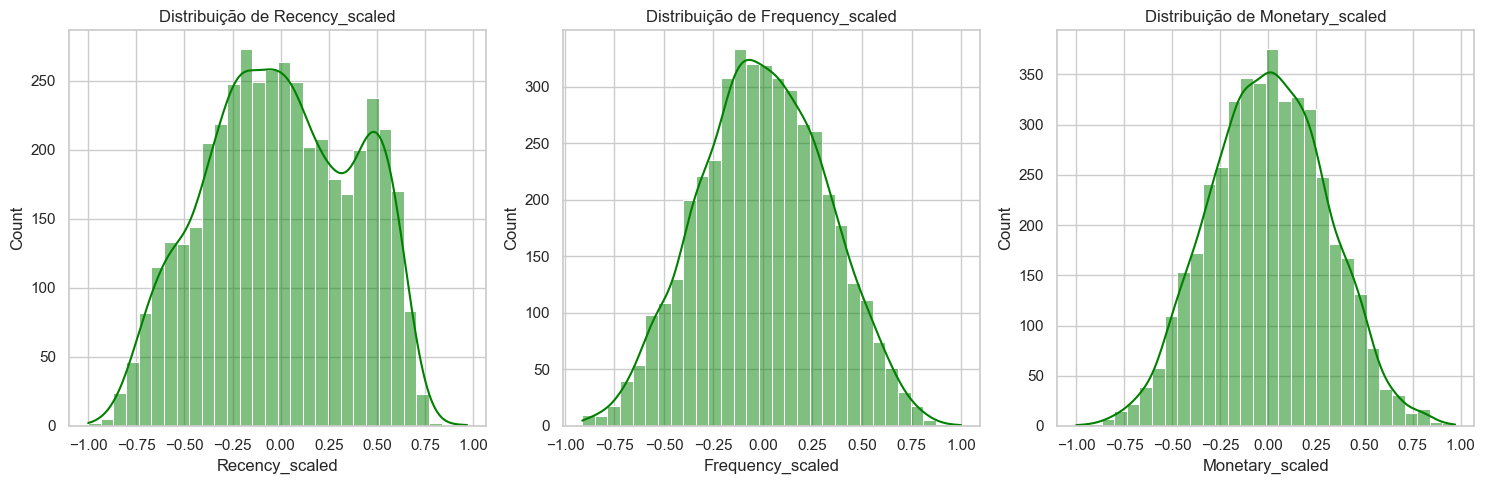

In [124]:
df_pandas_scaled= df_scaled.select("Recency_scaled", "Frequency_scaled", "Monetary_scaled").toPandas()
plot_distribution_hist(df_pandas_scaled, columns=["Recency_scaled", "Frequency_scaled", "Monetary_scaled"])

In [125]:
from pyspark.sql.functions import skewness, kurtosis

# Calcular assimetria e curtose para as colunas
columns = ["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]

for col_name in columns:
    skewness_value = df_scaled.select(skewness(col_name)).first()[0]
    kurtosis_value = df_scaled.select(kurtosis(col_name)).first()[0]
    
    print(f"Coluna: {col_name}")
    print(f"  Assimetria (Skewness): {skewness_value:.4f}")
    print(f"  Curtose (Kurtosis): {kurtosis_value:.4f}")
    print()

Coluna: Recency_scaled
  Assimetria (Skewness): -0.0641
  Curtose (Kurtosis): -0.8870



Coluna: Frequency_scaled
  Assimetria (Skewness): -0.0098
  Curtose (Kurtosis): -0.3834



Coluna: Monetary_scaled
  Assimetria (Skewness): 0.0131
  Curtose (Kurtosis): -0.2595



### 9. Análise de Redução Dimensionalidade

In [126]:
from pyspark.ml.feature import PCA

# Aplicar PCA com PySpark
pca = PCA(k=3, inputCol="maxAbsFeatures", outputCol="features_pca")
pca_model = pca.fit(df_scaled)

# Variância explicada
explained_variance = pca_model.explainedVariance.toArray()
print("Proporção de variância explicada por cada componente principal:")
print(explained_variance)

Proporção de variância explicada por cada componente principal:
[0.71408466 0.21974927 0.06616608]


Cumulative Variance: [0.71408466 0.93383392 1.        ]


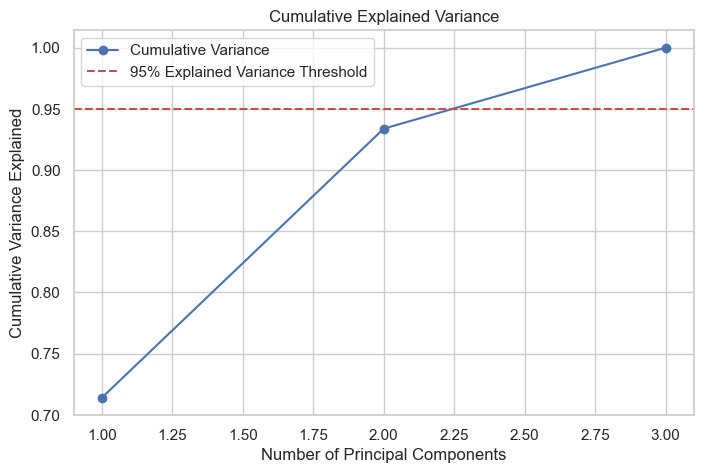

In [127]:
# Variância explicada acumulada usando a função sum do Python
cumulative_variance = np.cumsum(explained_variance)  # Forma mais eficiente

print("Cumulative Variance:", cumulative_variance)

# Plotando a variância explicada acumulada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label="Cumulative Variance")
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.axhline(0.95, color='r', linestyle='--', label="95% Explained Variance Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [128]:
# Determinar o número mínimo de componentes para atingir 95% de variância explicada
k_optimal = next(i for i, cumulative in enumerate(cumulative_variance) if cumulative >= 0.95)
print(f"Número ideal de componentes principais: {k_optimal}")

Número ideal de componentes principais: 2


In [129]:
# Obter os loadings (eigenvectors) do modelo PCA
loadings = pca_model.pc.toArray()

# Confirmar o número de variáveis originais no PCA
num_original_features = len(loadings)  # Número de linhas nos loadings

# Criar índices genéricos para os nomes das variáveis (se os nomes reais não estiverem disponíveis)
original_columns = [f"Feature_{i+1}" for i in range(num_original_features)]

# Criar um DataFrame com os loadings
import pandas as pd

loadings_df = pd.DataFrame(
    loadings, 
    columns=[f"PC{i+1}" for i in range(loadings.shape[1])],  # Componentes principais como colunas
    index=original_columns  # Nomes genéricos das variáveis como índice
)

# Exibir os loadings por variável
print("Loadings por Variável:")
print(loadings_df)


Loadings por Variável:
                PC1       PC2       PC3
Feature_1 -0.652136 -0.758015 -0.011488
Feature_2  0.558086 -0.469766 -0.684002
Feature_3  0.513087 -0.452474  0.729389


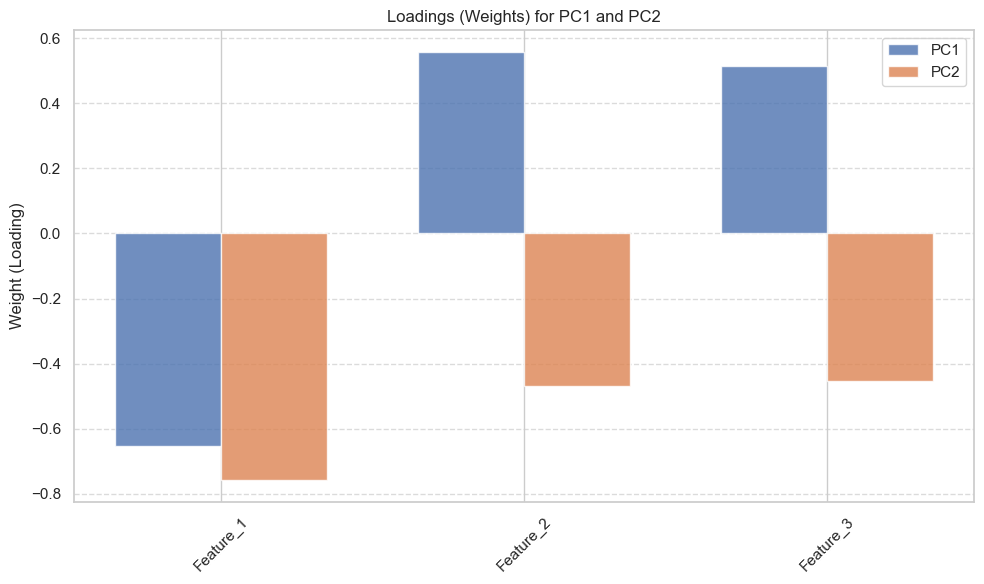

In [130]:
# Gerar o gráfico de Loadings para os dois primeiros componentes principais (PC1 e PC2)
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(loadings_df.index))  # Número de variáveis originais

plt.bar(x - bar_width / 2, loadings_df["PC1"], bar_width, label="PC1", alpha=0.8)
plt.bar(x + bar_width / 2, loadings_df["PC2"], bar_width, label="PC2", alpha=0.8)

plt.xticks(x, loadings_df.index, rotation=45)
plt.ylabel("Weight (Loading)")
plt.title("Loadings (Weights) for PC1 and PC2")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

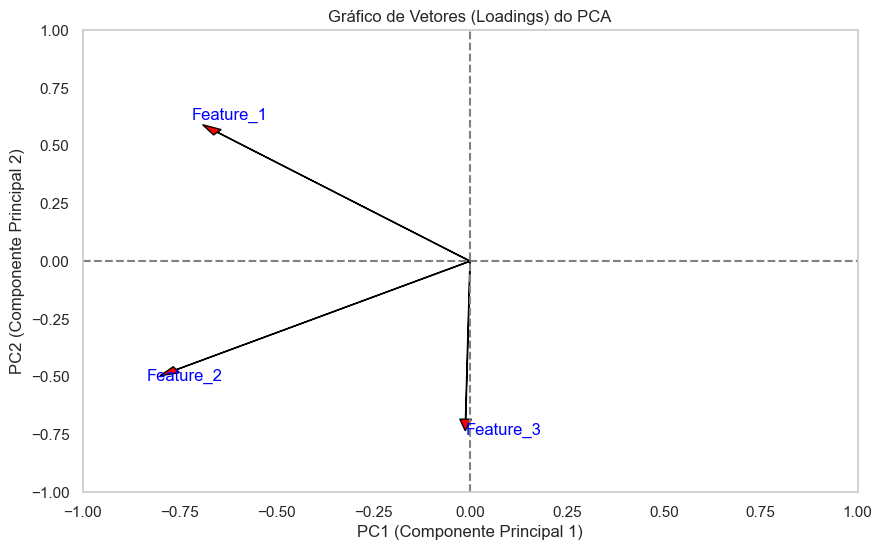

In [131]:
plot_pca_loadings(loadings_df, original_columns)

### 10. Redução de Dimensionalidade com PCA (Principal Component Analysis)

 **Escolha do número de componentes no PCA**

O PCA (Principal Component Analysis) foi utilizado para reduzir a dimensionalidade e identificar os componentes principais que melhor explicam a variância dos dados.

A variância explicada por cada componente foi analisada:

$
\begin{bmatrix}
0.7141 & 0.2197 & 0.0662
\end{bmatrix}
$

Com base nesses valores:

- O primeiro componente explica $71,4\%$ da variância total.
- O segundo componente explica $21,97\%$ da variância.
- O terceiro componente contribui com apenas $6,62\%$ da variância.

Como a **soma dos dois primeiros componentes já explica mais de $93\%$ da variância**, a escolha por **$k=2$** componentes principais foi ideal, pois:

1. Reduz a complexidade do modelo sem perda significativa de informação.
2. Evita sobreajuste** ao descartar componentes de baixa variância.
3. Facilita a visualização dos clusters em gráficos bidimensionais.

Essa escolha é especialmente relevante para modelos de **Fuzzy C-Means e K-Means**, onde a compactação dos dados em menos dimensões melhora a separação dos clusters e a interpretação dos resultados.

In [132]:
# Configurar o PCA
pca = PCA(k=2, inputCol="maxAbsFeatures", outputCol="features_pca")
pca_model = pca.fit(df_scaled)

# Transformar os dados
df_scaled_pca = pca_model.transform(df_scaled)
# df_scaled_pca.cache()
df_scaled_pca.unpersist()
# Exibir a variância explicada por cada componente
print(f"Proporção de variância explicada por cada componente principal: {pca_model.explainedVariance.toArray()}")

# Exibir as novas features reduzidas
df_scaled_pca.select("maxAbsFeatures").show(truncate=False)

Proporção de variância explicada por cada componente principal: [0.71408466 0.21974927]
+-----------------------------------------------------------------+
|maxAbsFeatures                                                   |
+-----------------------------------------------------------------+
|[-0.6567011886830989,0.617637250500858,0.4354503290589716]       |
|[-0.8187381522427452,0.4660586315869512,0.7138960516618419]      |
|[0.42071940351708137,0.012958496095147353,0.03748507593119939]   |
|[0.12202040381348582,0.3122296899765403,0.36478257191942864]     |
|[-0.22524822000116954,0.42765219012900124,0.3929594748643879]    |
|[0.49709269448552856,-0.6380929923414851,-0.2377685235516705]    |
|[0.22531102172906192,0.20329297723858217,0.27701890037088517]    |
|[-0.015788901145040782,0.17312737390429567,0.16096577578856208]  |
|[-0.15783324497785856,0.19356971692009864,0.1407268460201994]    |
|[-0.3105084413853158,0.5717699407992778,0.49508774648057496]     |
|[-0.6567011886830989,0.2449

### 11. Tratando as Variáveis RFM (Recency, Frequency, Monetary)

Após a criação das variáveis **RFM (Recency, Frequency, Monetary)** e sua normalização, foi realizado um novo tratamento dos dados, mesmo já tendo aplicado pré-processamentos anteriormente. Isso se justifica por alguns motivos:

1. **Novas distribuições e possíveis novos outliers:**  
   - A transformação das variáveis pode modificar a distribuição dos dados, criando novos pontos extremos que antes não eram considerados outliers.

2. **Melhor ajuste para técnicas de modelagem:**  
   - Modelos como **Fuzzy C-Means** e **K-Means** são sensíveis a escalas e valores extremos, então garantir que os dados estejam devidamente ajustados melhora a separação dos clusters.

3. **Reavaliação estatística após transformações:**  
   - Após normalizar as variáveis, refez-se a **Análise Exploratória dos Dados (EDA)** para verificar a nova estrutura dos dados e confirmar que a distribuição ficou mais adequada para a modelagem.


#### Tratando Valores Nulos

In [133]:
df_scaled_pca.select(["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]).show()
df_scaled_pca = df_scaled_pca.na.fill({"Recency_scaled": 0, "Frequency_scaled": 0, "Monetary_scaled": 0})

+--------------------+--------------------+--------------------+
|      Recency_scaled|    Frequency_scaled|     Monetary_scaled|
+--------------------+--------------------+--------------------+
| -0.6152979799498696|  0.5530906373110008|  0.3330986620298338|
| -0.7150066203722064| 0.36055711906833837|  0.6258198749150239|
|  0.3457873888582399|-0.12615928667613527|-0.07610912124760223|
| 0.03290150796386188| 0.18069808361137268| 0.25977513423967585|
|-0.28806544121987315|  0.3142040618513197|  0.2889715750011318|
| 0.43093510245496547| -0.6129252252185737|-0.35484945170144966|
|  0.1373951891753368| 0.06253661644677148| 0.16914784276556039|
|-0.10019344616606857|0.031139606933301194| 0.04996789756742203|
| -0.2295497290921737| 0.05235428996174952| 0.02925426215589619|
| -0.3593335034316566| 0.49320071691722994|  0.3952458805235518|
| -0.6152979799498696| 0.10684253743500484|  0.1035837578541287|
|  0.6026755908335711| -0.5039990453326764| -0.5027068615069752|
|-0.01492756102236...|-0.

#### Remoção de Outliers Usando IQR

In [134]:
# Mostrar o número de linhas antes do filtro
linhas_antes = df_scaled_pca.count()
print(f"Número de linhas antes da remoção de outliers: {linhas_antes}")

# Calcular limites IQR para Recency_scaled, Frequency_scaled e Monetary_scaled
def calcular_limites_iqr(df_scaled_pca, column):
    quantiles = df_scaled_pca.approxQuantile(column, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Definir os limites para cada variável
lower_Recency_scaled_bound, upper_Recency_scaled_bound = calcular_limites_iqr(df_scaled_pca, "Recency_scaled")
lower_Frequency_scaled_bound, upper_Frequency_scaled_bound = calcular_limites_iqr(df_scaled_pca, "Frequency_scaled")
lower_Monetary_scaled_bound, upper_Monetary_scaled_bound = calcular_limites_iqr(df_scaled_pca, "Monetary_scaled")

# Filtrar valores de RFM dentro dos limites
df_scaled_pca = df_scaled_pca.filter(
    (col("Recency_scaled") >= lower_Recency_scaled_bound) & (col("Recency_scaled") <= upper_Recency_scaled_bound) &
    (col("Frequency_scaled") >= lower_Frequency_scaled_bound) & (col("Frequency_scaled") <= upper_Frequency_scaled_bound) &
    (col("Monetary_scaled") >= lower_Monetary_scaled_bound) & (col("Monetary_scaled") <= upper_Monetary_scaled_bound)
)

# Mostrar o número de linhas após o filtro
linhas_depois = df_scaled_pca.count()
print(f"Número de linhas após a remoção de outliers: {linhas_depois}")

# Exibir a quantidade de outliers removidos
outliers_removidos = linhas_antes - linhas_depois
print(f"Número de outliers removidos: {outliers_removidos}")

Número de linhas antes da remoção de outliers: 4338


Número de linhas após a remoção de outliers: 4322
Número de outliers removidos: 16


### 12. Análise Estatística Inicial de RFM (Recency, Frequency, Monetary)

#### Analise Fatorial

In [135]:
from pyspark.ml.feature import PCA as PCA_Spark
from sklearn.decomposition import PCA as PCA_Sklearn

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
# Converter o DataFrame escalonado para Pandas
df_scaled_pca_pandas = df_scaled_pca.select("Recency_scaled", "Frequency_scaled", "Monetary_scaled").toPandas()

# Configurar e ajustar a Análise Fatorial
fa = FactorAnalyzer(n_factors=2, rotation="varimax")
fa.fit(df_scaled_pca_pandas)

# Extrair os fatores
factors = fa.transform(df_scaled_pca_pandas)

# Converter os fatores em um DataFrame para análise
factors_df_scaled_pca = pd.DataFrame(factors, columns=["Fator 1", "Fator 2"])

# Verificar a carga fatorial (correlação entre variáveis originais e os fatores)
cargas_fatoriais = pd.DataFrame(fa.loadings_, index=["Recency_scaled", "Frequency_scaled", "Monetary_scaled"], columns=["Fator 1", "Fator 2"])
print("Cargas Fatoriais:\n", cargas_fatoriais)

# Adicionar os fatores ao DataFrame original
df_scaled_pca_pandas[["Fator 1", "Fator 2"]] = factors_df_scaled_pca

Cargas Fatoriais:
                    Fator 1   Fator 2
Recency_scaled   -0.350395 -0.502647
Frequency_scaled  0.738151  0.484343
Monetary_scaled   0.754824  0.432129


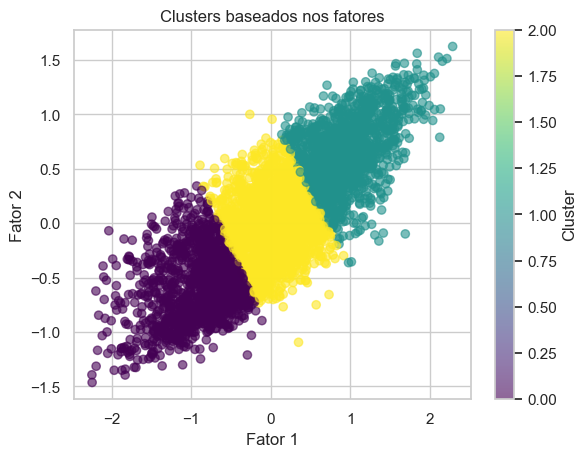

In [136]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Aplicar K-Means nos fatores
kmeans = KMeans(n_clusters=3, random_state=42)
df_scaled_pca_pandas["Cluster"] = kmeans.fit_predict(factors_df_scaled_pca)

# Visualizar clusters baseados nos fatores
plt.scatter(factors_df_scaled_pca["Fator 1"], factors_df_scaled_pca["Fator 2"], c=df_scaled_pca_pandas["Cluster"], cmap="viridis", alpha=0.6)
plt.title("Clusters baseados nos fatores")
plt.xlabel("Fator 1")
plt.ylabel("Fator 2")
plt.colorbar(label="Cluster")
plt.show()

#### Distância média entre pontos

In [137]:
from pyspark.ml.linalg import Vectors
from scipy.spatial.distance import pdist
import numpy as np

# Amostrar uma fração dos dados para calcular as distâncias (opcional)
# sampled_df = df_scaled_pca.sample(fraction=0.1, seed=42)

# Converter as colunas escalonadas diretamente para matriz NumPy
data = np.array(df_scaled_pca.select("Recency_scaled", "Frequency_scaled", "Monetary_scaled").rdd.map(lambda row: [row.Recency_scaled, row.Frequency_scaled, row.Monetary_scaled]).collect())

# Calcular distâncias entre os pontos usando pdist
distances = pdist(data)  # Calcula todas as distâncias entre pares
average_distance = np.mean(distances)  # Distância média entre todos os pares
print(f"Distância média entre pontos: {average_distance:.4f}")

Distância média entre pontos: 0.7347


#### Medidas de posição

In [138]:
print(f"Medidas de posição: ")
# Cálculo da mediana
median_quantity = df_scaled_pca.approxQuantile("Recency_scaled", [0.5], 0.01)[0]
print(f"\nMediana de Recency_scaled: {median_quantity}")

# Cálculo dos interquantis Q1 e Q3 para unitPrice
q1, q2, q3 = df_scaled_pca.approxQuantile("Recency_scaled", [0.25, 0.5, 0.75], 0.01)
print(f"Q1 de Recency_scaled: {q1}\nQ2 de Recency_scaled: {q2}\nQ3 de Recency_scaled: {q3}")

Medidas de posição: 



Mediana de Recency_scaled: -0.012439080068783283


Q1 de Recency_scaled: -0.28668526184796067
Q2 de Recency_scaled: -0.012439080068783283
Q3 de Recency_scaled: 0.3043996434081007


In [139]:
print(f"Medidas de posição: ")
# Cálculo da mediana
median_quantity = df_scaled_pca.approxQuantile("Frequency_scaled", [0.5], 0.01)[0]
print(f"\nMediana de Frequency_scaled: {median_quantity}")

# Cálculo dos interquantis Q1 e Q3 para unitPrice
q1, q2, q3 = df_scaled_pca.approxQuantile("Frequency_scaled", [0.25, 0.5, 0.75], 0.01)
print(f"Q1 de Frequency_scaled: {q1}\nQ2 de Frequency_scaled: {q2}\nQ3 de Frequency_scaled: {q3}")

Medidas de posição: 



Mediana de Frequency_scaled: -0.004444844103489523


Q1 de Frequency_scaled: -0.22538726170052445
Q2 de Frequency_scaled: -0.004444844103489523
Q3 de Frequency_scaled: 0.22452906355268468


In [140]:
print(f"Medidas de posição: ")
# Cálculo da mediana
median_quantity = df_scaled_pca.approxQuantile("Monetary_scaled", [0.5], 0.01)[0]
print(f"\nMediana de Monetary_scaled: {median_quantity}")

# Cálculo dos interquantis Q1 e Q3 para unitPrice
q1, q2, q3 = df_scaled_pca.approxQuantile("Monetary_scaled", [0.25, 0.5, 0.75], 0.01)
print(f"Q1 de Monetary_scaled: {q1}\nQ2 de Monetary_scaled: {q2}\nQ3 de Monetary_scaled: {q3}")

Medidas de posição: 



Mediana de Monetary_scaled: -0.0016777171237971683


Q1 de Monetary_scaled: -0.21274672386853283
Q2 de Monetary_scaled: -0.0007116532972907685
Q3 de Monetary_scaled: 0.2070461804211168


### 13. Análise de Distribuição

#### Cálculo de Assimetria e Curtose

In [141]:
from pyspark.sql.functions import skewness, kurtosis

# Calcular assimetria e curtose para as colunas
columns = ["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]

for col_name in columns:
    skewness_value = df_scaled_pca.select(skewness(col_name)).first()[0]
    kurtosis_value = df_scaled_pca.select(kurtosis(col_name)).first()[0]
    
    print(f"Coluna: {col_name}")
    print(f"  Assimetria (Skewness): {skewness_value:.4f}")
    print(f"  Curtose (Kurtosis): {kurtosis_value:.4f}")
    print()

Coluna: Recency_scaled
  Assimetria (Skewness): -0.0626
  Curtose (Kurtosis): -0.8867



Coluna: Frequency_scaled
  Assimetria (Skewness): -0.0047
  Curtose (Kurtosis): -0.4161



Coluna: Monetary_scaled
  Assimetria (Skewness): 0.0091
  Curtose (Kurtosis): -0.3647



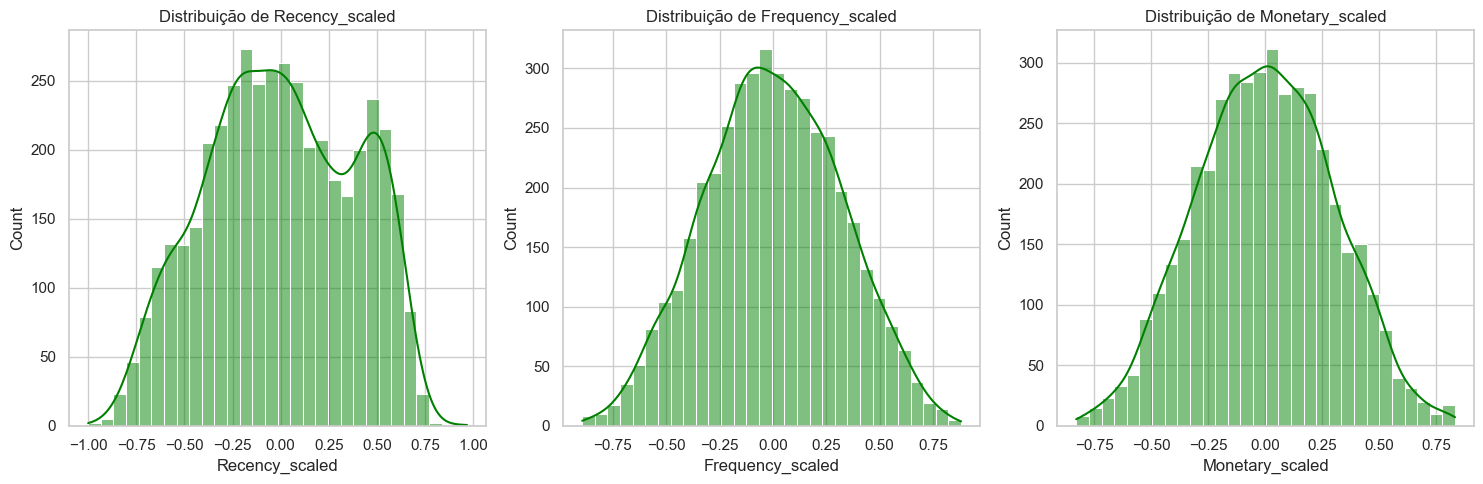

In [142]:
df_pandas_scaled_pca= df_scaled_pca.select("Recency_scaled", "Frequency_scaled", "Monetary_scaled").toPandas()
plot_distribution_hist(df_pandas_scaled_pca, columns=["Recency_scaled", "Frequency_scaled", "Monetary_scaled"])

#### Cálculo dos Z-Scores

In [143]:
from pyspark.sql.functions import col, mean as _mean, stddev as _stddev

# Coluna para calcular os z-scores
columns = ["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]

# Iterar sobre as colunas para calcular os z-scores
for column in columns:
    # Calcular média e desvio padrão da coluna
    stats = df_scaled_pca.select(_mean(col(column)).alias("mean"),
                               _stddev(col(column)).alias("stddev")).collect()[0]    
    mean_value = stats["mean"]
    stddev_value = stats["stddev"]
    
    # Adicionar uma nova coluna com o z-score
    zscore_column = f"z_{column}"
    df_scaled_pca = df_scaled_pca.withColumn(zscore_column, (col(column) - mean_value) / stddev_value)

# Exibir os dados com os z-scores
df_scaled_pca.show()

+-------+---------+------------------+--------------------+--------------------+--------------------+-------------+---------------+--------------+----------+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------------------+
|Recency|Frequency|          Monetary|      Recency_scaled|    Frequency_scaled|     Monetary_scaled|Recency_score|Frequency_score|Monetary_score|CustomerID|      maxAbsFeatures|     features_vector|RFM|        features_pca|    z_Recency_scaled|  z_Frequency_scaled|   z_Monetary_scaled|
+-------+---------+------------------+--------------------+--------------------+--------------------+-------------+---------------+--------------+----------+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------------------+
|      2|      350| 3507.710000000001| -0.6567011886830989|   0.617637250500858|  0.4354503290589716|            5|              5|     

### 14. Análise de Correlação

***Mapa de Correlação - RFM***

- Correlação Positiva: Indica que as variáveis tendem a variar juntas. Quando uma aumenta, a outra também tende a aumentar. Em geral, alta correlação positiva pode indicar proximidade, especialmente se usarmos medidas de distância como a distância euclidiana.  

- Correlação Negativa: Indica que as variáveis tendem a variar em direções opostas. Quando uma aumenta, a outra tende a diminuir. Nesse caso, a correlação negativa pode indicar distância, mesmo que os valores absolutos das variáveis sejam próximos.

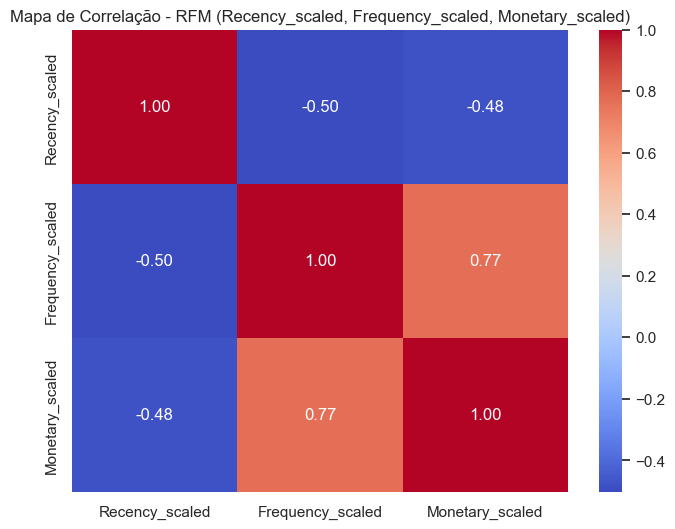

In [144]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rfm_columns = ["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]
df_rfm = df_scaled_pca.select(rfm_columns).dropna()  # Remove NaN para evitar erros


vec_assembler = VectorAssembler(inputCols=rfm_columns, outputCol="features_vec")
df_vec = vec_assembler.transform(df_rfm).select("features_vec")

correlation_matrix = Correlation.corr(df_vec, "features_vec").head()[0].toArray()

correlation_df = pd.DataFrame(correlation_matrix, index=rfm_columns, columns=rfm_columns)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Mapa de Correlação - RFM (Recency_scaled, Frequency_scaled, Monetary_scaled)")
plt.show()

#### Mutual Information Scores

In [145]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Converter para Pandas
df_pandas = df_scaled_pca.select("Recency_scaled", "Frequency_scaled", "Monetary_scaled").toPandas()
mutual_info = mutual_info_regression(
    df_pandas[["Recency_scaled", "Frequency_scaled"]],
    df_pandas["Monetary_scaled"]
)
print("Mutual Information Scores:\n", mutual_info)

Mutual Information Scores:
 [0.119085   0.57239056]


In [146]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Converter para Pandas
df_pandas = df_scaled_pca.select("Recency_scaled", "Frequency_scaled", "Monetary_scaled").toPandas()
mutual_info = mutual_info_regression(
    df_pandas[["Monetary_scaled", "Frequency_scaled"]],
    df_pandas["Recency_scaled"]
)
print("Mutual Information Scores:\n", mutual_info)

Mutual Information Scores:
 [0.11907996 0.1627267 ]


In [147]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Converter para Pandas
df_pandas = df_scaled_pca.select("Recency_scaled", "Frequency_scaled", "Monetary_scaled").toPandas()
mutual_info = mutual_info_regression(
    df_pandas[["Monetary_scaled", "Recency_scaled"]],
    df_pandas["Frequency_scaled"]
)
print("Mutual Information Scores:\n", mutual_info)

Mutual Information Scores:
 [0.57247241 0.16287071]


### 15. Análise de Multicolinearidade

#### VIF (Variance Inflation Factor)

In [148]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

df_pandas = df_scaled_pca.select("Recency", "Frequency_scaled", "Monetary_scaled").toPandas()
vif_data = pd.DataFrame()
vif_data["feature"] = df_pandas.columns
vif_data["VIF"] = [variance_inflation_factor(df_pandas.values, i) for i in range(df_pandas.shape[1])]
print(vif_data)

            feature       VIF
0           Recency  1.136399
1  Frequency_scaled  2.467147
2   Monetary_scaled  2.458529


### 16. Análise Gráfica das Variáveis RFM

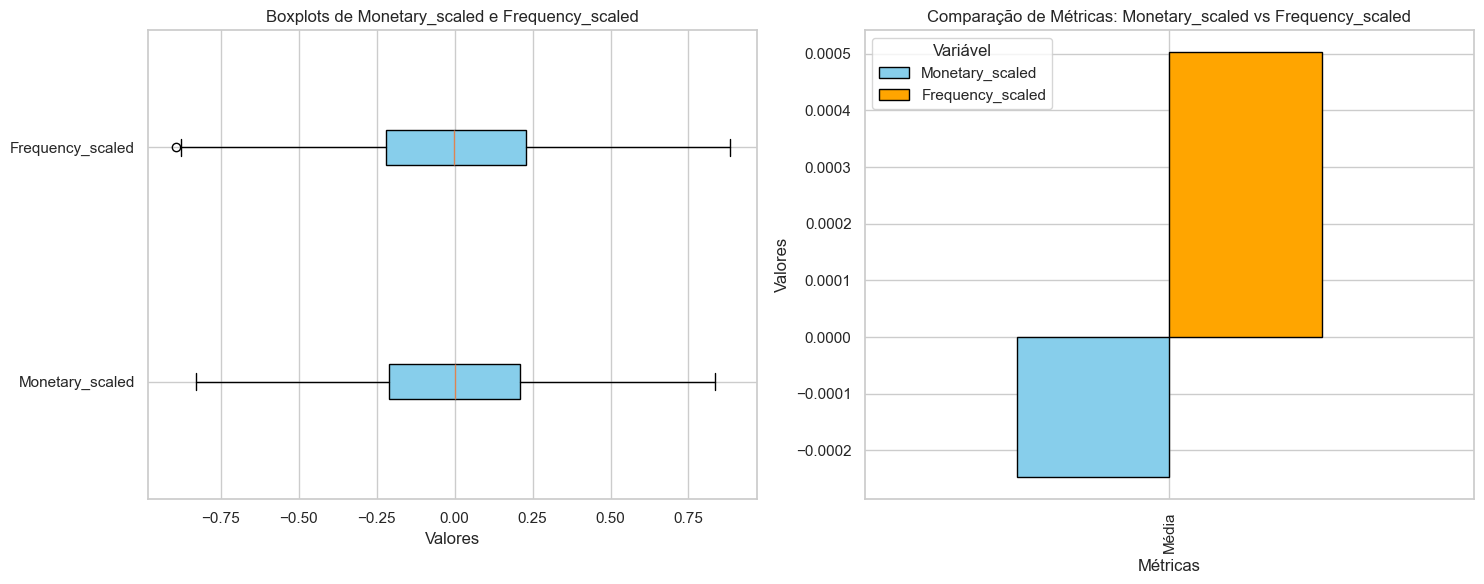

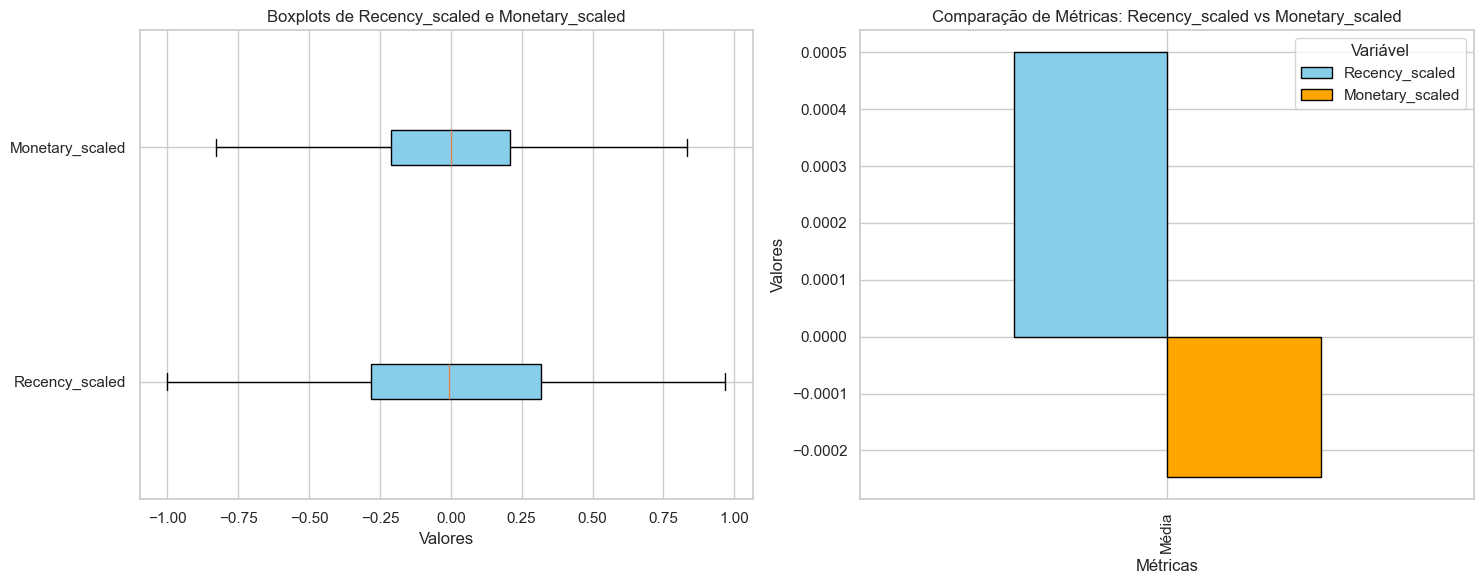

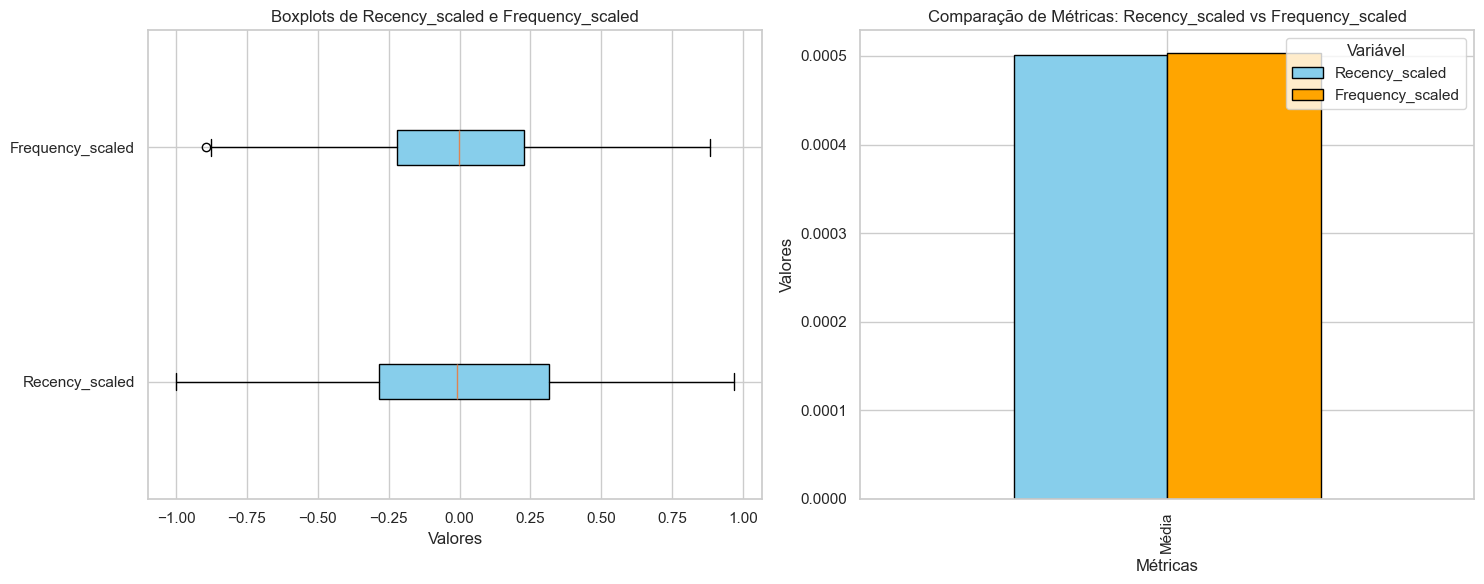

In [149]:
plot_box_and_bar_spark(df_scaled_pca, "Monetary_scaled", "Frequency_scaled")
plot_box_and_bar_spark(df_scaled_pca, "Recency_scaled", "Monetary_scaled")
plot_box_and_bar_spark(df_scaled_pca, "Recency_scaled", "Frequency_scaled")

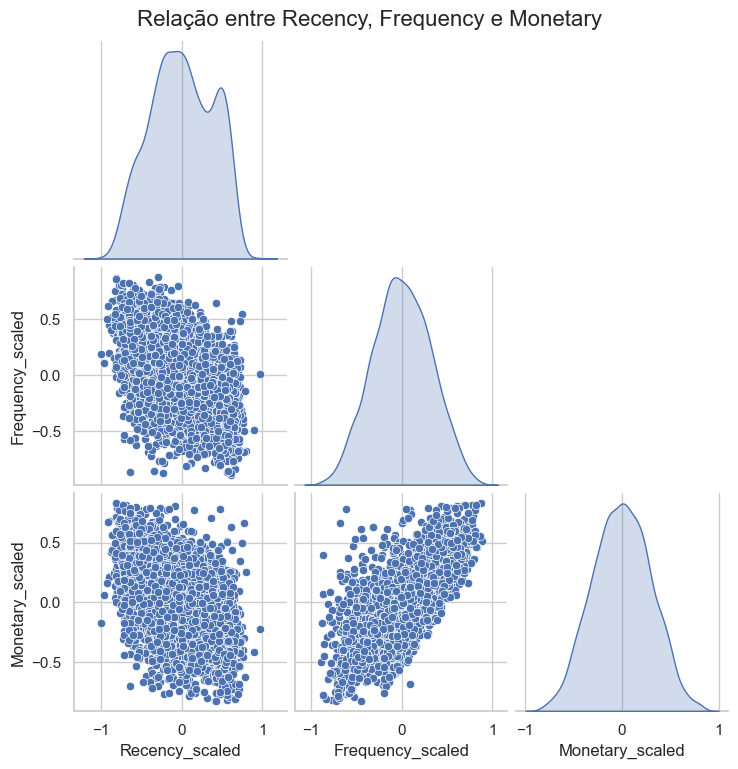

In [150]:
plot_rfm_relationships(df_scaled_pca,  ["Recency_scaled", "Frequency_scaled", "Monetary_scaled"])

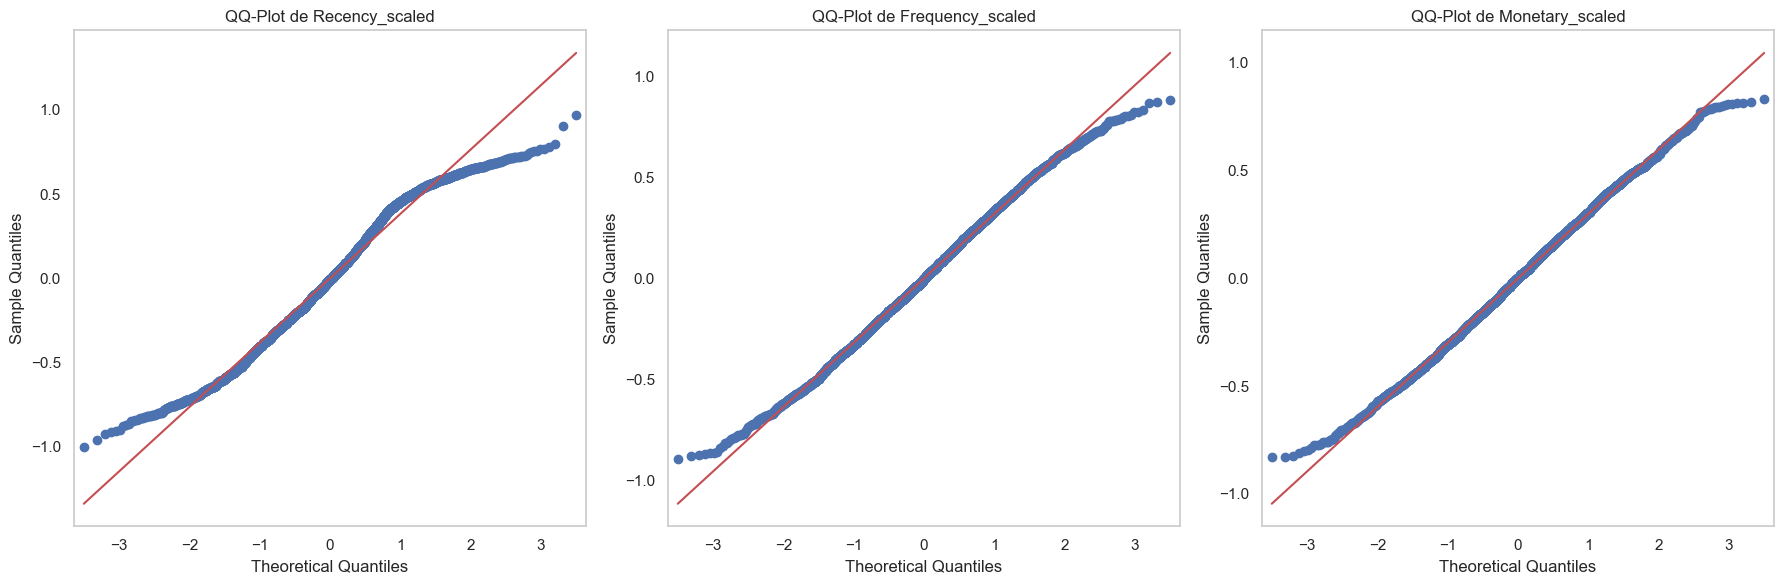

In [151]:
plot_qq_pyspark(df_scaled_pca,  ["Recency_scaled", "Frequency_scaled", "Monetary_scaled"])

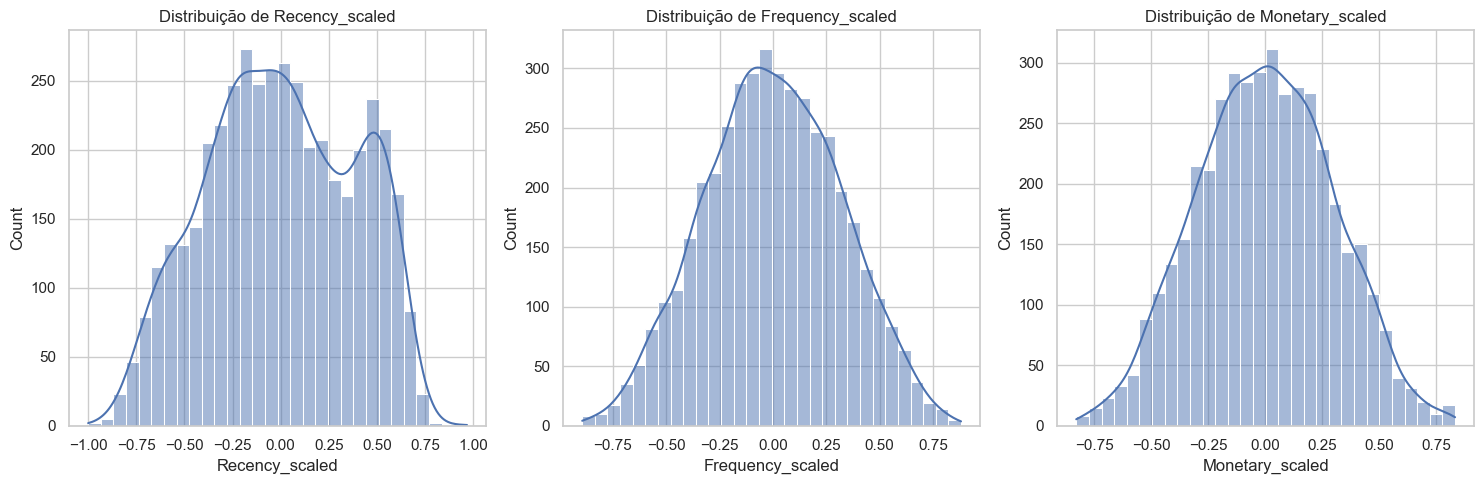

In [152]:
plot_histograms(df_scaled_pca, ["Recency_scaled", "Frequency_scaled", "Monetary_scaled"])


### 17. Salvando os Dados para Modelagem

In [153]:
from pyspark.sql import DataFrame
import os

# Obter o caminho absoluto do diretório do projeto
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))

# Caminho completo para a pasta src/data/interim
src_path = os.path.join(project_path, 'RID184082_Desafio07/project/src/data/processed_data')

# Caminho onde o DataFrame será salvo
output_path = os.path.join(src_path, 'df.parquet')

# Salvar o DataFrame em formato Parquet
df_scaled_pca.write.mode("overwrite").parquet(output_path)

print(f"DataFrame de engenharia de features salvo com sucesso em: {output_path}")

spark.stop()

DataFrame de engenharia de features salvo com sucesso em: /Users/rodrigocampos/Documents/RID184082_Desafio07/project/src/data/processed_data/df.parquet
